# Self-Refine Test 

## 1. Load environment

In [15]:
%pip install dashscope python-dotenv urllib3
%pip install tiktoken

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [32]:
import os
import dashscope
import sys
import platform
import dashscope
import time
import re
import csv
import pandas as pd
from dotenv import load_dotenv
from typing import Tuple, Optional, Dict, List, Any
from dashscope.api_entities.dashscope_response import Message
import matplotlib.pyplot as plt

In [3]:
# 1) Load environment (DASHSCOPE_API_KEY)

load_dotenv("dashscope_api_key.env", override=True)
api_key = os.getenv("DASHSCOPE_API_KEY")
if not api_key:
    print("DASHSCOPE_API_KEY not found!")

# Print environment information
print("Current environment information")
print("-" * 40)
print(f"Python version: {sys.version}")
print(f"Platform system: {platform.system()} {platform.release()}")
print(f"DASHSCOPE_API_KEY read successfully: {'✅ Yes' if api_key else '❌ No'}")

Current environment information
----------------------------------------
Python version: 3.10.16 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:19:12) [MSC v.1929 64 bit (AMD64)]
Platform system: Windows 10
DASHSCOPE_API_KEY read successfully: ✅ Yes


## 2. Call Function


The **`call_model`** function is designed to invoke a large language model (LLM) through DashScope in a way that **preserves multi-round context**. Rather than passing a one-time prompt, it accepts a **list of messages**—each labeled with a role (`system`, `user`, or `assistant`)—that collectively represent the conversation history. This approach enables an iterative, dialogic style of interaction with the model:

1. **Conversation as a List of Messages**  
   - We store every piece of text that shapes the conversation (system instructions, user questions, model replies) in a Python list called `messages`.  
   - Each element is a structure with fields like `role` (e.g., `system`, `user`, `assistant`) and `content` (the actual text).

2. **System-Level Instructions**  
   - At the start of the list, we often include a “system” message that defines the model’s role or behavior (“You are a rigorous math tutor…”).  
   - Unlike a single-pass prompt, this system message persists throughout every exchange, ensuring the LLM remains consistent in style and purpose.

3. **User Queries and Model Responses**  
   - For each round of interaction, we append a new `user` message with the user’s request or instructions.  
   - The model’s reply then comes back as `assistant` text, which we likewise insert into the `messages` list.  
   - Over time, this list accumulates the entire conversation history.

4. **Self-Refine Alignment**  
   - Because all prior messages (including the model’s own previous answers) are visible in the list, the LLM can read and critique its own past output.  
   - This structure naturally supports the **feedback → refinement** cycle described in the Self-Refine paradigm, as the model sees both the problem statement and its earlier reasoning steps whenever it generates new content.

5. **DashScope Invocation**  
   - On each call, `call_model` sends the current `messages` list to the DashScope service, specifying the temperature and other parameters.  
   - DashScope’s API returns the model’s fresh reply (an “assistant” role string) and usage statistics (like token counts).  
   - We update the `messages` with the new assistant message, thus preserving context for the next round.

6. **Context Preservation**  
   - By passing **the entire conversation history** each time, we mimic the idea of a session that retains prior knowledge, enabling multi-step problem-solving or iterative refinement.  
   - This stands in contrast to single-prompt APIs that only see their immediate input. Here, the model is re-supplied with both the user’s original questions and any subsequent instructions or feedback, capturing the logic of self-critique and incremental improvement.

7. **Benefits and Considerations**  
   - **Enhanced Consistency**: The model maintains continuity across multiple rounds, remembering earlier details or constraints.  
   - **Scalability**: Because the conversation grows each iteration, users should watch out for token limit constraints and trim older or less relevant messages if needed.  
   - **Clearer Control Flow**: The code that orchestrates Self-Refine can systematically add new messages (feedback requests, draft solutions, refined outputs, etc.), making the dialogue flow explicit and easy to follow.

In [4]:
LOG_FILE = "logs/self_refine_logs.txt"  # you can rename it

def log_print(*args, **kwargs):
    """
    Print to console AND append the same text to a log file.
    """
    # 1) Print normally to console
    print(*args, **kwargs)
    
    # 2) Build the same text string
    text_str = " ".join(str(arg) for arg in args)
    # If there are any 'sep', 'end' etc. from kwargs, handle them. For simplicity we skip here.
    
    # 3) Write to file
    with open(LOG_FILE, mode="a", encoding="utf-8") as f:
        f.write(text_str + "\n")

In [ ]:
def call_model(
    messages: List[Message],
    model_name: str = "qwen2.5-math-1.5b-instruct",
    temperature: float = 0.2,
    max_retries: int = 50,
    retry_delay: float = 1.0,
    verbose: bool = True
) -> Tuple[Optional[str], Dict[str, Any]]:
    """
    Call the DashScope model with a list of messages (including system, user, assistant).

    Returns:
        content: The assistant's text response (None if error).
        usage:   usage dict (may include token counts, etc.), or {}
    """
    last_exception = None
    api_key = os.getenv("DASHSCOPE_API_KEY")
    if not api_key:
        log_print("DASHSCOPE_API_KEY not found!")
        return None, {}

    for attempt in range(1, max_retries + 1):
        try:
            response = dashscope.Generation.call(
                api_key=api_key,
                model=model_name,
                messages=messages,
                temperature=temperature,
                result_format="message",
                timeout=60
            )

            status_code = response.get("status_code", 200)  # type: ignore
            if status_code != 200:
                if verbose:
                    log_print(f"⚠️[Attempt {attempt}/{max_retries}] Rate limit! Retrying in {retry_delay}s...")
                    log_print(f"⚠️[Warning] {response.get('message', '')}  {response.get('code', '')}") # type: ignore
                time.sleep(retry_delay)
                continue

            # Parse out the model's reply
            content = response["output"]["choices"][0]["message"]["content"]  # type: ignore
            usage = response.get("usage", {})  # type: ignore
            return content, usage

        except Exception as e:
            last_exception = e
            log_print(f"⚠️[Attempt {attempt}/{max_retries}] Exception occurred: {e}")
            log_print(f"⚠️[Warning] {response.get('message', '')}  {response.get('code', '')}") # type: ignore
            time.sleep(retry_delay)

    raise RuntimeError(f"❌ All {max_retries} attempts failed.") from last_exception

In [6]:
if __name__ == "__main__":
    question = "A baker makes 20 cupcakes. He eats 2 and gives away 3. How many does he have left?"
    system_prompt = (
        "You are a rigorous math tutor. "
        "You solve problems step by step in detail and ensure mathematical correctness. "
        "Then, at the end, on a new line, write:\n"
        "Final Answer: <numeric result>\n"
        "Do not include any additional text after that line."
    )
    messages = [
        Message(role="system", content=system_prompt),
        Message(role="user", content=f"Solve the following problem step-by-step:\n{question}")
    ]

    content, usage = call_model(
        messages=messages,
        model_name="qwen2.5-math-1.5b-instruct",
        temperature=0.2,
        verbose=True
    )

    print("\n=== Model Output ===")
    print("Assistant Response:\n", content)
    print("Usage:", usage)


=== Model Output ===
Assistant Response:
 To determine how many cupcakes the baker has left, we need to follow these steps:

1. Start with the initial number of cupcakes the baker has, which is 20.
2. Subtract the number of cupcakes the baker eats, which is 2.
3. Subtract the number of cupcakes the baker gives away, which is 3.

Let's perform the calculations step-by-step:

1. Initial number of cupcakes: 20
2. After eating 2 cupcakes: \(20 - 2 = 18\)
3. After giving away 3 cupcakes: \(18 - 3 = 15\)

So, the number of cupcakes the baker has left is \(\boxed{15}\).
Usage: {"input_tokens": 97, "output_tokens": 149, "total_tokens": 246, "cached_tokens": 0}


## 3. Extract Answer

In [23]:
def extract_final_answer(response_text: str) -> str:
    """
    Extract final numeric answer from model output.
    Priority:
    1. Last 'Final Answer: ...'
    2. Last '\\boxed{...}'
    3. Last number
    4. Fallback: full trimmed text
    """
    # 1. Final Answer (last one)
    final_matches = re.findall(r"(?i)final answer\s*:\s*([+-]?\d+(?:\.\d+)?)", response_text)
    if final_matches:
        return final_matches[-1].strip()

    # 2. Last \boxed{...}
    boxed = re.findall(r"\\boxed\{([^}]*)\}", response_text)
    if boxed:
        return boxed[-1].strip()

    # 3. Last number
    numbers = re.findall(r"[+-]?\d+(?:\.\d+)?", response_text)
    if numbers:
        return numbers[-1].strip()

    # 4. Fallback
    return response_text.strip()

In [24]:
test_cases_updated = {
    "Only Final Answer line": ("Final Answer: 42", "42"),
    "Multiple Final Answers, should take last": (
        "Final Answer: <numeric result>\n...\nFinal Answer: 123", "123"
    ),
    "Boxed only, no Final Answer": (
        "The answer is \\boxed{999}.", "999"
    ),
    "Both Final Answer and Boxed, take Final Answer (last)": (
        "Here's a box: \\boxed{77}. Then Final Answer: 88", "88"
    ),
    "No Final/Box, fallback to last number": (
        "She counted 3, then 4. Final result: 7.5", "7.5"
    ),
    "Only prompt Final Answer, real answer in box": (
        "Final Answer: <numeric result>\nNo improvement needed.\nThe result is \\boxed{140}.", "140"
    ),
    "No numbers at all": (
        "The model couldn't answer this question.", "The model couldn't answer this question."
    )
}

# Evaluate and prepare results
eval_results = []
for description, (text, expected) in test_cases_updated.items():
    result = extract_final_answer(text)
    eval_results.append({
        "Description": description,
        "Input": text,
        "Expected": expected,
        "Extracted": result,
        "Passed": result == expected
    })
eval_results

[{'Description': 'Only Final Answer line',
  'Input': 'Final Answer: 42',
  'Expected': '42',
  'Extracted': '42',
  'Passed': True},
 {'Description': 'Multiple Final Answers, should take last',
  'Input': 'Final Answer: <numeric result>\n...\nFinal Answer: 123',
  'Expected': '123',
  'Extracted': '123',
  'Passed': True},
 {'Description': 'Boxed only, no Final Answer',
  'Input': 'The answer is \\boxed{999}.',
  'Expected': '999',
  'Extracted': '999',
  'Passed': True},
 {'Description': 'Both Final Answer and Boxed, take Final Answer (last)',
  'Input': "Here's a box: \\boxed{77}. Then Final Answer: 88",
  'Expected': '88',
  'Extracted': '88',
  'Passed': True},
 {'Description': 'No Final/Box, fallback to last number',
  'Input': 'She counted 3, then 4. Final result: 7.5',
  'Expected': '7.5',
  'Extracted': '7.5',
  'Passed': True},
 {'Description': 'Only prompt Final Answer, real answer in box',
  'Input': 'Final Answer: <numeric result>\nNo improvement needed.\nThe result is \\b

## 4. Self-Refine

The `self_refine` function implements a multi-round refinement process for math problem solving, following the Self-Refine paradigm. It uses a single, persistent `messages` list to simulate a continuous dialogue with the model, allowing it to build upon its own previous answers and feedback.

### 4.1 Key Steps:

1. **Initial Draft**
   - The function begins by prompting the model to generate a step-by-step solution to the math problem.
   - This initial response is saved as an assistant message in the session.

2. **Feedback and Refinement Loop**
   - Each round, the model is asked to critique its last answer.
   - It then receives its own feedback and is prompted to revise accordingly.
   - All exchanges (questions, answers, feedback) are appended to the same `messages` list, preserving full context.

3. **Session-Based Memory**
   - By keeping the entire conversation in a single session, the model sees the full reasoning history at every step.
   - This allows coherent self-correction and aligns with the original Self-Refine paper’s methodology.

4. **Early Stopping (with Safeguard)**
   - The model may exit early if it declares the answer already correct — but only after completing at least **one** refinement cycle.
   - This ensures robustness without redundant computation.

5. **Final Output**
   - The last refined answer is parsed to extract the final numeric result.
   - The function returns this result, the full answer text, number of rounds used, and total token usage.

### 4.2 Key Points & Considerations

- **Rigorous System Prompt**  
  - The model is cast in the role of a “rigorous math tutor,” ensuring detailed reasoning and clarity in every generation.
  - >Since both temperature and top_p can control the diversity of generated text, it is recommended that you only set one of them. 
    - So I lowered the temperature a bit, reduced the diversity appropriately, and ensured the rigor of the mathematical results.

- **Feedback-Refine Loop**  
  The model alternates between critiquing its own output and improving it, thereby aiming to catch logical or computational mistakes in a structured manner.

- **Mandatory Improvement Round**  
  The function will not accept an immediate “no improvement” response for the first refinement attempt. This ensures that, at a minimum, the model has made one pass to reevaluate its initial draft.

- **Early Stop Heuristic**  
  After at least one refinement, if the model states that no further changes are needed, the loop terminates early. This method is a convenience to reduce overhead when the model is sufficiently confident.

- **No Absolute Guarantee of Correctness**  
  While the approach often enhances solution quality, the model’s own judgment may still fail to catch subtler errors. For high-stakes scenarios, external validation (e.g., test suites or domain experts) is recommended.

- **Return Structure**  
  The final output includes:
  1. **`final_text`**: The model’s last refined draft (full textual answer).  
  2. **`final_answer`**: The numeric or short result extracted from `final_text`.  
  3. **`ended_on_round`**: Which round triggered the exit, either because of reaching the maximum iteration or early stopping.  
  4. **`total_usage`**: A cumulative usage metric (e.g., total tokens).

This procedure illustrates a practical way to nudge large language models toward more self-critical and iteratively improved answers, particularly for math-oriented tasks.

In [25]:
from tiktoken import get_encoding

def extract_conclusion_sentences(text: str, max_lines: int = 6) -> str:
    """
    Try to extract the most important reasoning or final answer lines from a long model response.
    Priority:
      1. Lines containing key phrases (e.g., 'final answer', 'therefore', etc.)
      2. Lines containing numeric equations or boxed answers
      3. Last few lines as fallback
    """
    lines = text.strip().split("\n")
    candidates = []

    # Define conclusion-style keywords
    keywords = ["final answer", "therefore", "hence", "thus", "so", "we get", "in conclusion"]

    for line in lines:
        line_lower = line.lower()
        if any(kw in line_lower for kw in keywords):
            candidates.append(line)
            continue

        # Match simple numeric conclusions, equations, boxed answers
        if re.search(r"(=|≈|→|\banswer\b|\bboxed)", line_lower):
            candidates.append(line)

    # If we found enough matches, return the last few
    if candidates:
        return "\n".join(candidates[-max_lines:]).strip()

    # Fallback: last N lines
    fallback = lines[-max_lines:]
    return "\n".join(fallback).strip()

def log_token_count(messages, verbose=True, label="Current"):
    """
    Print the total token count of all messages (for debugging long context issues).
    """
    if not verbose:
        return
    try:
        encoding = get_encoding("cl100k_base")
        total = sum(len(encoding.encode(msg.content)) for msg in messages)
        log_print(f"🧾[Token Count] {label}: {total} tokens in messages.")
    except Exception as e:
        log_print(f"⚠️ Failed to compute token count: {e}")

def self_refine(
    question: str,
    rounds: int = 5,
    verbose: bool = True,
    model_name: str = "qwen2.5-math-1.5b-instruct",
    temperature: float = 0.2,
) -> Dict:
    """
    Conduct multiple rounds of 'Self-Refine' for a math problem in a single session (messages list),
    returning the final refined answer.

    Args:
        question (str): The math problem to be solved.
        rounds (int): The maximum number of refinement iterations.
        verbose (bool): Whether to print intermediate steps.
        model_name (str): The name of the language model to call.
        temperature (float): Sampling temperature for controlling randomness in the output.

    Returns:
        dict with keys:
        {
            "final_text"      : str or None, 
            "final_answer"    : str or None,
            "ended_on_round"  : int,
            "total_usage"     : int  # or float, depending on actual usage measure
        }
    """
    
    def count_tokens(text: str, encoding_name="cl100k_base") -> int:
        encoding = get_encoding(encoding_name)
        return len(encoding.encode(text))

    def prune_messages_by_token(messages: List[Message], max_tokens: int = 1500) -> List[Message]:
        system_msg = messages[0]
        kept_messages = [system_msg]
        total_tokens = count_tokens(system_msg.content) # type: ignore
        for msg in reversed(messages[1:]):
            msg_tokens = count_tokens(msg.content) # type: ignore
            if total_tokens + msg_tokens > max_tokens:
                break
            kept_messages.insert(1, msg)
            total_tokens += msg_tokens
        return kept_messages
    
    # -----------------------------
    # 1) Construct an initial 'messages' list
    # -----------------------------
    # (A) system prompt
    system_content = (
        "You are a rigorous math tutor. "
        "You solve problems step by step in detail and ensure mathematical correctness. "
        "When you finish, on a new line, write:\n"
        "Final Answer: <numeric result>\n"
        "Do not include any additional text after that line."
    )
    messages = [Message(role="system", content=system_content)]

    # (B) user: problem statement
    #   This is akin to the old "first_prompt_template"
    user_intro = (
        "Solve the following math problem with detailed reasoning. "
        "Explain your steps clearly and logically. "
        "At the end, please write:\n"
        "Final Answer: <number>\n\n"
        f"{question}"
    )
    messages.append(Message(role="user", content=user_intro))

    total_usage_tokens = 0
    ended_on_round = 0
    final_answer = None
    
    # -----------------------------
    # 2) Generate the initial draft (assistant)
    # -----------------------------
    try:
        initial_draft, usage_init = call_model(
            messages=messages,
            model_name=model_name,
            temperature=temperature,
            verbose=verbose
        )
    except Exception as e:
        log_print("❌[Error] Failed to generate initial draft.")
        log_print(f"    └─ Reason: {str(e)}")
        raise
    if usage_init is None:
        usage_init = {"total_tokens": 0}
    total_usage_tokens += usage_init["total_tokens"]

    if initial_draft is None:
        if verbose:
            log_print("❌[Error] Initial draft generation returned None.")
        return {
            "final_text": None,
            "final_answer": None,
            "ended_on_round": 0,
            "total_usage": total_usage_tokens
        }

    # Save the assistant's response to messages
    messages.append(Message(role="assistant", content=initial_draft))

    if verbose:
        log_print("\n✅━━ [Initial Draft Generated] ━━✅")
        log_print(initial_draft)
        log_print("")

    current_answer = initial_draft

    # -----------------------------
    # 3) Iterative refinement
    # -----------------------------
    for i in range(rounds):
        round_index = i + 1
        if verbose:
            log_print(f"[Refinement Round {round_index} of {rounds}]")

        # 3a) user asks for feedback
        short_draft = extract_conclusion_sentences(current_answer, max_lines=4)

        feedback_request = (
            f"Below is the math problem and your draft solution. Please analyze it:\n\n"
            f"Problem:\n{question}\n\n"
            f"Draft Answer (truncated):\n{short_draft}\n\n"
            "Point out any errors or omissions, suggest improvements. "
            "If it's already correct, say 'no improvement needed'."
        )
        messages.append(Message(role="user", content=feedback_request))
        messages = prune_messages_by_token(messages)

        try:
            log_token_count(messages, verbose, label=f"Before Feedback Round {round_index}")
            feedback, usage_fb = call_model(
                messages=messages,
                model_name=model_name,
                temperature=temperature,
                verbose=verbose
            )
        except Exception as e:
            log_print(f"❌[Error] Feedback generation failed at round {round_index}.")
            log_print(f"    └─ Reason: {str(e)}")
            raise
        if usage_fb is None:
            usage_fb = {"total_tokens": 0}
        total_usage_tokens += usage_fb["total_tokens"]

        if feedback is None:
            if verbose:
                log_print("❌[Error] Feedback generation returned None. Stopping.")
            ended_on_round = round_index
            break

        # Save model's feedback to messages (assistant role)
        messages.append(Message(role="assistant", content=feedback))
        messages = prune_messages_by_token(messages)

        if verbose:
            log_print("✅[Feedback Received]")
            log_print(feedback)
            log_print("")

        # 3b) check if "no improvement" (but only if round_index > 1 to ensure at least 1 round of refine)
        lower_fb = feedback.lower()
        if round_index > 1 and (
            "no improvement" in lower_fb
            or "solution is correct" in lower_fb
            or "already correct" in lower_fb
        ):
            if verbose:
                log_print("✅[Notice] Feedback indicates no further improvement is needed. Stopping early.")
            ended_on_round = round_index
            break

        # 3c) user instructs to refine
        short_feedback = extract_conclusion_sentences(feedback, max_lines=4)
        refine_request = (
            f"Here is the math problem, your truncated draft, and the truncated feedback:\n\n"
            f"Problem:\n{question}\n\n"
            f"Draft (summary):\n{short_draft}\n\n"
            f"Feedback (summary):\n{short_feedback}\n\n"
            "Please refine the draft solution. "
            "At the end, write 'Final Answer: <number>'. "
            "Make sure the numeric result is correct."
        )
        messages.append(Message(role="user", content=refine_request))
        messages = prune_messages_by_token(messages)

        try:
            log_token_count(messages, verbose, label=f"Before Refine Round {round_index}")
            refined_answer, usage_refine = call_model(
                messages=messages,
                model_name=model_name,
                temperature=temperature,
                verbose=verbose
            )
        except Exception as e:
            log_print(f"❌[Error] Refinement failed at round {round_index}.")
            log_print(f"    └─ Reason: {str(e)}")
            raise
        if usage_refine is None:
            usage_refine = {"total_tokens": 0}
        total_usage_tokens += usage_refine["total_tokens"]

        if refined_answer is None:
            if verbose:
                log_print("⚠️[Warning] Refinement returned None. Using current version and stopping.")
            ended_on_round = round_index
            break

        # Save new refined answer as assistant
        messages.append(Message(role="assistant", content=refined_answer))
        messages = prune_messages_by_token(messages)
        
        current_answer = refined_answer

        if verbose:
            log_print("✅[Refined Answer]")
            log_print(current_answer)
            log_print("")

        ended_on_round = round_index
        extracted = extract_final_answer(current_answer)
        if extracted:
            final_answer = extracted

    # -----------------------------
    # 4) Extract final numeric answer
    # -----------------------------
    final_answer_post = extract_final_answer(current_answer)
    if final_answer_post:
        final_answer = final_answer_post
    # -----------------------------
    # 5) Return
    # -----------------------------
    return {
        "final_text": current_answer,
        "final_answer": final_answer,
        "ended_on_round": ended_on_round,
        "total_usage": total_usage_tokens
    }

## 5. Single Demo Question Test

In [26]:
if __name__ == "__main__":
    question = "Janet's ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?"

    # Gold answer
    gold_answer = "18"

    # Do self-consistency
    result = self_refine(
        question=question,
        model_name="qwen2.5-math-1.5b-instruct",
        rounds=3
    )
    final_text = result["final_text"]
    final_answer = result["final_answer"]
    ended_on_round = result["ended_on_round"]
    total_usage = result["total_usage"]

    # Compare with gold
    is_correct = (final_answer.strip() == gold_answer.strip())
    response_length = len(final_text)

    
    # Print the info
    print("\n━━━ ★  SINGLE QUESTION TEST  ★ ━━━")
    print(f"Question:\n{question}\n")
    print(f"Predicted Final Answer: {final_answer}")
    print(f"Gold Answer: {gold_answer}")
    print(f"Correct? {is_correct}")
    print(f"Response Length (chars): {response_length}")
    print(f"Ended on Round: {ended_on_round}")
    print(f"Total Usage (tokens): {total_usage}")
    print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n")


✅━━ [Initial Draft Generated] ━━✅
To determine how much Janet makes every day at the farmers' market, we need to follow these steps:

1. Calculate the total number of eggs laid by the ducks each day.
2. Determine how many eggs Janet sells at the farmers' market each day.
3. Calculate the revenue from selling the eggs at the farmers' market.

**Step 1: Calculate the total number of eggs laid by the ducks each day.**

Janet's ducks lay 16 eggs per day.

**Step 2: Determine how many eggs Janet sells at the farmers' market each day.**

Janet eats 3 eggs for breakfast every morning and bakes 4 eggs for her friends every day. Therefore, the total number of eggs she does not sell is:
\[ 3 + 4 = 7 \text{ eggs} \]

The number of eggs Janet sells at the farmers' market each day is:
\[ 16 - 7 = 9 \text{ eggs} \]

**Step 3: Calculate the revenue from selling the eggs at the farmers' market.**

Janet sells each egg for $2. Therefore, the revenue from selling 9 eggs is:
\[ 9 \times 2 = 18 \text{ do

## 6. GSM8K main_test 

In [27]:
# =============================
# Your helper functions
# =============================
def extract_numeric(ans: str) -> str:
    """Clean extracted answer by removing $, units, commas, and extra tokens."""
    ans = ans.strip()
    ans = re.sub(r"[^0-9.\-]", "", ans)
    return ans

def extract_gold_answer(gold_text: str) -> str:
    """Extract the numeric answer from GSM8K-style '#### <number>' line."""
    match = re.search(r"####\s*(\d+(?:\.\d+)?)", str(gold_text))
    if match:
        return match.group(1)
    numbers = re.findall(r"\d+(?:\.\d+)?", str(gold_text))
    if numbers:
        return numbers[-1]
    return str(gold_text).strip()

def is_correct_with_tolerance(pred: str, gold: str, epsilon: float = 1e-5) -> bool:
    """Compare pred and gold within a tolerable margin of error."""
    try:
        return abs(float(pred) - float(gold)) < epsilon
    except ValueError:
        return pred.strip() == gold.strip()

def is_abnormal_answer(ans: str, max_repeat: int = 10, max_len: int = 100) -> bool:
    ans = ans.strip()
    if ans == "":
        return True
    # Empty or overly long numeric string
    if len(ans) > max_len:
        return True
    # Check for repeated characters like 777777...
    if re.match(r"^(\d)\1{" + str(max_repeat) + r",}$", ans):
        return True
    return False

# =============================
# (Import or define) self_refine
# Here we assume you have the single-session version of self_refine
# or any correct version that returns a dict with keys:
#  "final_text", "final_answer", "ended_on_round", "total_usage"
# =============================
# from your_module import self_refine

# =============================
# Load GSM8K CSV dataset
# =============================
df = pd.read_csv("dataset/GSM8K/main_test.csv")
num_samples = -1  # -1 for processing the full dataset; or set a smaller number for debugging
subset = df if num_samples == -1 else df.head(num_samples)

save_path = "results/results_gsm8k_self_refine_qwen.csv"
done_indices = set()

# If we want to resume from an existing CSV, load it and skip done indices
if os.path.exists(save_path):
    try:
        existing_df = pd.read_csv(save_path)
        done_indices = set(existing_df["index"].tolist())
        log_print(f"🔁 Resuming from existing results in '{save_path}'. Rows done: {len(done_indices)}")
    except Exception as e:
        log_print(f"⚠️ Could not read existing file: {e}")

# =============================
# Main Evaluation Loop
# =============================
for idx, row in subset.iterrows():
    if idx in done_indices:
        continue

    question = row["question"]
    gold_answer_raw = row["answer"]  # original gold text, e.g. "#### 15"

    log_print(f"\n=== Processing index {idx} ===")
    log_print("Question:", question)

    # 1) Extract gold numeric
    gold_clean = extract_gold_answer(gold_answer_raw)

    # 2) Call self_refine
    try:
        refine_result = self_refine(
            question=question,
            rounds=5,
            verbose=True,
            model_name="qwen2.5-math-1.5b-instruct",  # or any model you want
            temperature=0.2
        )
        final_text = refine_result["final_text"]
        predicted_answer = refine_result["final_answer"] or ""
        ended_on_round = refine_result["ended_on_round"]
        total_usage = refine_result["total_usage"]
    except Exception as e:
        log_print(f"[Error] {e}")
        final_text = ""
        predicted_answer = ""
        ended_on_round = 0
        total_usage = 0

    # 3) Clean and validate predicted answer
    pred_clean = extract_numeric(predicted_answer)
    is_invalid = is_abnormal_answer(pred_clean)

    if is_invalid:
        pred_clean = "INVALID"
        correct = None
    else:
        correct = is_correct_with_tolerance(pred_clean, gold_clean)

    response_length = len(final_text)

    # 4) Determine status symbol for logging
    if is_invalid:
        status_symbol = "⚠️"
    elif correct:
        status_symbol = "✅"
    else:
        status_symbol = "❌"

    # 5) Print compact log line
    log_print(f"{status_symbol} Pred: {pred_clean} | Gold: {gold_clean} | Correct: {correct} | Round: {ended_on_round} | Tokens: {total_usage}")

    # 6) Save result to CSV
    row_dict = {
        "id": idx,
        "question": question,
        "gold_answer": gold_answer_raw,
        "gold_clean": gold_clean,
        "predicted_answer": final_text,
        "predicted_clean": pred_clean,
        "is_invalid": is_invalid,
        "is_correct": correct,
        "ended_on_round": ended_on_round,
        "total_usage": total_usage
    }

    write_header = not os.path.exists(save_path)
    with open(save_path, "a", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=row_dict.keys())
        if write_header:
            writer.writeheader()
        writer.writerow(row_dict)

    log_print(f"Saved result for index {idx}")

log_print("\nAll done!")

⚠️ Could not read existing file: No columns to parse from file

=== Processing index 0 ===
Question: Janet’s ducks lay 16 eggs per day. She eats three for breakfast every morning and bakes muffins for her friends every day with four. She sells the remainder at the farmers' market daily for $2 per fresh duck egg. How much in dollars does she make every day at the farmers' market?

✅━━ [Initial Draft Generated] ━━✅
To determine how much Janet makes every day at the farmers' market, we need to follow these steps:

1. Calculate the total number of eggs laid by the ducks each day.
2. Determine how many eggs Janet eats for breakfast and bakes for her friends.
3. Find out how many eggs are left for sale at the farmers' market.
4. Calculate the revenue from selling these eggs at $2 per egg.

Let's start with the first step:

1. Janet's ducks lay 16 eggs per day.

2. Janet eats 3 eggs for breakfast every morning and bakes 4 eggs for her friends every day. So, the total number of eggs used each 

### 6.1 Analyze this CSV file

In [ ]:
column_names = [
    "id",
    "question",
    "gold_answer",
    "gold_clean",
    "predicted_answer",
    "predicted_clean",
    "is_invalid",
    "is_correct",
    "ended_on_round",
    "total_usage"
]

df = pd.read_csv("results/results_gsm8k_self_refine_qwen.csv", 
                 names=column_names, 
                 header=0, 
                 encoding="ISO-8859-1")

In [31]:
# --- Correct data analysis code ---
total_samples = len(df)
invalid_samples = df['is_invalid'].sum()
valid_samples = total_samples - invalid_samples
correct_samples = df.loc[(df['is_correct'] == True) & (df['is_invalid'] == False)].shape[0]
incorrect_samples = df.loc[(df['is_correct'] == False) & (df['is_invalid'] == False)].shape[0]

# Output overall statistics
print("===== Overall statistics =====")
print(f"Total number of samples: {total_samples}")
print(f"Invalid number of samples (INVALID): {invalid_samples} ({invalid_samples/total_samples:.2%})")
print(f"Valid samples: {valid_samples} ({valid_samples/total_samples:.2%})")
print(f"Valid samples: {correct_samples} ({correct_samples/valid_samples:.2%})")
print(f"Valid samples: {incorrect_samples} ({incorrect_samples/valid_samples:.2%})")

# Token usage
avg_tokens = df['total_usage'].mean()
max_tokens = df['total_usage'].max()
min_tokens = df['total_usage'].min()

print("\n===== Token usage =====")
print(f"Average usage tokens: {avg_tokens:.2f}")
print(f"Maximum tokens: {max_tokens}")
print(f"Minimum tokens: {min_tokens}")

# ended_on_round distribution
print("\n===== Early termination round distribution =====")
round_counts = df['ended_on_round'].value_counts().sort_index()
for round_num, count in round_counts.items():
    print(f"End of round {round_num}: {count} ({count/total_samples:.2%})")

===== Overall statistics =====
Total number of samples: 1318
Invalid number of samples (INVALID): 10 (0.76%)
Valid samples: 1308 (99.24%)
Valid samples: 1074 (82.11%)
Valid samples: 234 (17.89%)

===== Token usage =====
Average usage tokens: 8687.48
Maximum tokens: 28253
Minimum tokens: 0

===== Early termination round distribution =====
End of round 0: 10 (0.76%)
End of round 2: 781 (59.26%)
End of round 3: 14 (1.06%)
End of round 4: 1 (0.08%)
End of round 5: 512 (38.85%)


Statistical information at the end of each round:
   ended_on_round  total  correct  incorrect  invalid  correct_pct  \
0               0     10        0          0       10     0.000000   
1               2    781      670        111        0     0.857875   
2               3     14       13          1        0     0.928571   
3               4      1        1          0        0     1.000000   
4               5    512      390        122        0     0.761719   

   incorrect_pct  invalid_pct  
0       0.000000          1.0  
1       0.142125          0.0  
2       0.071429          0.0  
3       0.000000          0.0  
4       0.238281          0.0  


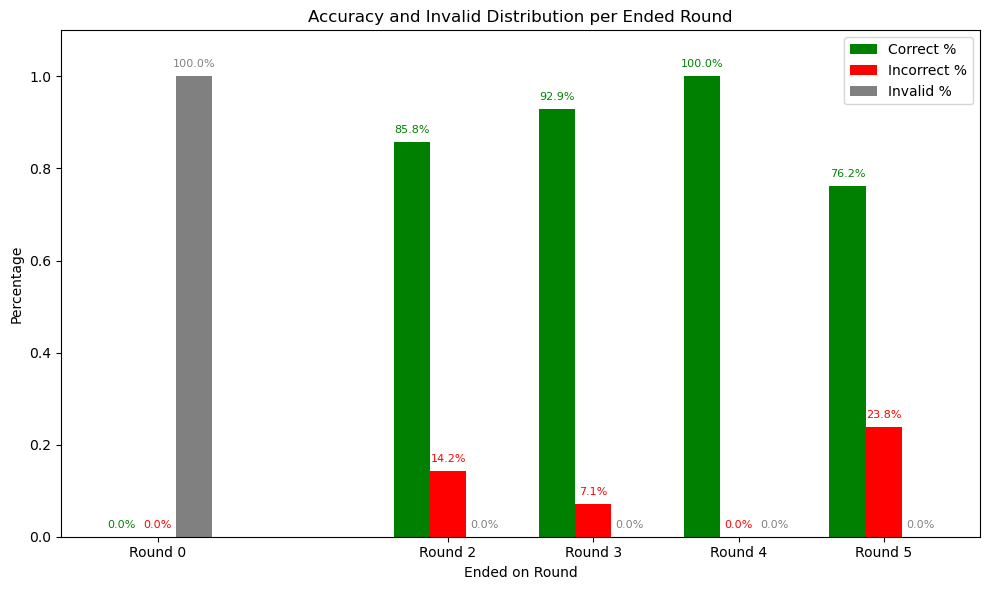

In [33]:
round_stats = df.groupby("ended_on_round").agg(
    total=('id', 'count'),
    correct=('is_correct', lambda x: ((x == True).sum())),
    incorrect=('is_correct', lambda x: ((x == False).sum())),
    invalid=('is_invalid', 'sum')
).reset_index()

round_stats['correct_pct'] = round_stats['correct'] / round_stats['total']
round_stats['incorrect_pct'] = round_stats['incorrect'] / round_stats['total']
round_stats['invalid_pct'] = round_stats['invalid'] / round_stats['total']

print("Statistical information at the end of each round:")
print(round_stats)

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
x = round_stats['ended_on_round']

ax.bar(x - bar_width, round_stats['correct_pct'], width=bar_width, label='Correct %', color='green')
ax.bar(x, round_stats['incorrect_pct'], width=bar_width, label='Incorrect %', color='red')
ax.bar(x + bar_width, round_stats['invalid_pct'], width=bar_width, label='Invalid %', color='gray')

ax.set_xlabel('Ended on Round')
ax.set_ylabel('Percentage')
ax.set_title('Accuracy and Invalid Distribution per Ended Round')
ax.set_xticks(x)
ax.set_xticklabels([f'Round {int(i)}' for i in x])
ax.legend()

for idx, row in round_stats.iterrows():
    ax.text(row['ended_on_round'] - bar_width, row['correct_pct'] + 0.02, f"{row['correct_pct']:.1%}", ha='center', color='green', fontsize=8)
    ax.text(row['ended_on_round'], row['incorrect_pct'] + 0.02, f"{row['incorrect_pct']:.1%}", ha='center', color='red', fontsize=8)
    ax.text(row['ended_on_round'] + bar_width, row['invalid_pct'] + 0.02, f"{row['invalid_pct']:.1%}", ha='center', color='gray', fontsize=8)

plt.ylim(0, 1.1)
plt.tight_layout()
plt.show()